In [1]:
import requests, json, time
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC 

%matplotlib inline

/home/omar/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# master_df = pd.concat([sci_clean, clean_fut_df])
##RIght here if starting anew:
sci_df = pd.read_csv('./data_csvs/clean_sci.csv')
fut_df = pd.read_csv('./data_csvs/clean_fut.csv')
master_df = pd.concat([sci_df, fut_df], ignore_index=True)
#Drop the extraneous index column
master_df.drop('Unnamed: 0', 1, inplace=True)


#gonna map the subreddit to a 1 if 'askcience', 0 otherwise
map_dict= {
    "askscience": 1,
    "Futurology": 0
}
master_df['subreddit'] = master_df['subreddit'].map(map_dict)

#might as well remove selftext, num_comments, and ups because I don't want to use those right now
dropfeats= ['ups', 'selftext', 'num_comments']
master_df.drop(dropfeats, 1, inplace=True)

**for feature engineering I will**:
1. see if there's a question mark in the title (this is kind of cheating, may not use it ultimately)
2. count the number of words
3. count the number of words in title not in stopwords


In [3]:
import re
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))
master_df['processed'] = master_df['title'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))
master_df['qmark']= master_df['title'].apply(lambda x: 1 if '?' in x else 0 )
master_df['words_not_stopword'] = master_df['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))

**Those are all the features I want now. Next step is to train_test_split**

In [4]:
X= master_df.drop(columns= ['subreddit', 'title'])
y= master_df['subreddit']
X_train, X_test, y_train, y_test= train_test_split(X,y)
# X_train.columns = X_test.columns = ['data_'+col for col in X_train.columns]

In [5]:
X_train= X_train.reset_index(drop=True)
y_train= y_train.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)

**The main pre-processing I will be doing is EITHER CountVectorize or Tf-idf. words_not_stopwords is on approx the same scale, so I won't bother normalizing it. The main thing is to create a CV pipeline and a TFidf pipeline**

In [133]:
# I would like to automate this process, but the best I can do atm is: 
#Create the different permutations of CV and TFIDF, save a different version of X_train and X_test

In [6]:
#Count Vecc options: Max_features, n_gram_range(), binary
#TFIDF: 
cv= CountVectorizer(stop_words='english', ngram_range=(1,3)) 
tfidf= TfidfVectorizer(stop_words='english', ngram_range=(1,3))

# Some Vectorizing notes:
# When Stop words are left in, all the top features are stop words
# When stop words are removed, test accuracy falls by about 4-5%
# when ngram range starts >1, accuracy suffers. (1,3) is best

trX_cv = cv.fit_transform(X_train['processed'])
teX_cv= cv.transform(X_test['processed'])

trX_tf = tfidf.fit_transform(X_train['processed'])
teX_tf= tfidf.transform(X_test['processed'])

In [12]:
# tfidf MultinomialNB()
tf_mult= MultinomialNB()
# tf_mult.fit(trX_tf.todense(), y_train) # Not needed to turn to dense
tf_mult.fit(trX_tf, y_train)

# print(tf_mult.score(trX_tf.todense(), y_train),tf_mult.score(teX_tf.todense(), y_test))
print(tf_mult.score(trX_tf, y_train),tf_mult.score(teX_tf, y_test))

tf_myd= dict(zip(tfidf.get_feature_names(), list(tf_mult.coef_)[0]))

# to get a clue as to what's going on with NB, let's look at the coefs. The smallest magnitude words are the most
# distinguishing

sorted(tf_myd.items(), key= lambda x: abs(x[1]), reverse=False)[:10]

1.0 0.9038076152304609


[('does', -7.9176303687593705),
 ('like', -8.52108110127995),
 ('water', -8.666734074146092),
 ('light', -8.808093004284842),
 ('sun', -8.828877641649086),
 ('space', -8.835347068947964),
 ('earth', -8.843391293265132),
 ('possible', -8.859137233099803),
 ('human', -8.990483738398865),
 ('body', -9.019797566547032)]

In [13]:
# cv MultinomialNB()cv_
cv_mult= MultinomialNB()
# cv_mult.fit(trX_cv.todense(), y_train)
cv_mult.fit(trX_cv, y_train)

# print(cv_mult.score(trX_cv.todense(), y_train),cv_mult.score(teX_cv.todense(), y_test))
print(cv_mult.score(trX_cv, y_train),cv_mult.score(teX_cv, y_test))

cv_myd= dict(zip(cv.get_feature_names(), list(cv_mult.coef_)[0]))

# to get a clue as to what's going on with NB, let's look at the coefs. The smallest magnitude words are the most
# distinguishing

sorted(cv_myd.items(), key= lambda x: abs(x[1]), reverse=False)[:10]

1.0 0.8897795591182365


[('does', -5.975155809066059),
 ('like', -6.7289276114424394),
 ('water', -6.9757876893739645),
 ('light', -7.224249048672465),
 ('just', -7.304291756346001),
 ('space', -7.332462633312698),
 ('earth', -7.361450170185949),
 ('time', -7.361450170185949),
 ('human', -7.422074792002384),
 ('possible', -7.453823490316965)]

In [137]:
#I've settled on a somewhat acceptable CV/TFIDF. Now I'm going to insert them into their 
#respective DFs
# vecdf_par =[
#     (trX_cv, X_train)
#     (trX_tf, X_train)
#     (teX_cv, X_test)
#     (teX_tf, X_test)    
# ]
cvdf_tr= pd.DataFrame(trX_cv.todense(), columns = cv.get_feature_names())
cvdf_te= pd.DataFrame(teX_cv.todense(), columns = cv.get_feature_names())
tfdf_tr= pd.DataFrame(trX_tf.todense(), columns = tfidf.get_feature_names())
tfdf_te= pd.DataFrame(teX_tf.todense(), columns = tfidf.get_feature_names())
cv_tr_df= pd.concat([X_train.drop(columns='processed'), cvdf_tr], axis=1)#, ignore_index=True)
cv_te_df= pd.concat([X_test.drop(columns='processed'), cvdf_te], axis=1)#, ignore_index=True)
tf_tr_df= pd.concat([X_train.drop(columns='processed'), tfdf_tr], axis=1)#, ignore_index=True)
tf_te_df= pd.concat([X_test.drop(columns='processed'), tfdf_te], axis=1)#, ignore_index=True)

**To Recap: Right now I have both TFIDF and Count Vectorized Corpuses. Now I will run them through various classifiers to see if I can get better**

In [138]:
#courtesy of http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [139]:
models1 = {
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC()
}

params1 = {
    'ExtraTreesClassifier': { 'n_estimators': [16, 32] },
    'RandomForestClassifier': { 'n_estimators': [16, 32] },
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
}

In [140]:
# Do not run this because my computer nearly crashed and ran out of memory
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(cv_tr_df, y_train, scoring='f1', n_jobs=7)

Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=7)]: Done   6 out of   6 | elapsed:    9.1s finished


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=7)]: Done   6 out of   6 | elapsed:    8.5s finished
[Parallel(n_jobs=7)]: Done   6 out of   6 | elapsed:  2.4min finished


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/omar/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/omar/miniconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/omar/miniconda3/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/home/omar/miniconda3/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/home/omar/miniconda3/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/home/omar/miniconda3/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/omar/miniconda3/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/omar/miniconda3/lib/python3.6/multiprocessing/popen_fork.py", line 19, in __in

AttributeError: 'NoneType' object has no attribute 'terminate'

In [142]:
#what I have left over before the crash
helper1.score_summary(sort_by='max_score')

ExtraTreesClassifier
RandomForestClassifier
AdaBoostClassifier


,estimator,min_score,mean_score,max_score,std_score,n_estimators
1,ExtraTreesClassifier,0.977778,0.980397,0.981744,0.00185262,32
5,AdaBoostClassifier,0.977597,0.97904,0.981744,0.00191399,32
4,AdaBoostClassifier,0.977867,0.9791,0.979757,0.000872151,16
0,ExtraTreesClassifier,0.971545,0.974947,0.977688,0.0025512,16
3,RandomForestClassifier,0.953908,0.960749,0.965377,0.00493693,32
2,RandomForestClassifier,0.930612,0.941297,0.951613,0.00857746,16


In [ ]:
et = ExtraTreesClassifier(n_estimators=32)
et.fit(cv_tr_df, y_train)

et.score(cv_tr_df, y_train) #Returns 1

et.score(cv_te_df, y_test) # Returns .98, not bad

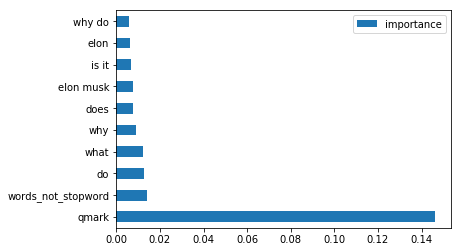

In [151]:
feat_importance = pd.DataFrame(et.feature_importances_, cv_tr_df.columns, columns = ['importance'])

feat_importance.sort_values('importance', ascending=False).head(10).plot(kind='barh')

In [162]:
#same concept but with tf_tr_df
et2 = ExtraTreesClassifier(n_estimators=32)
et2.fit(tf_tr_df, y_train)

et2.score(tf_tr_df, y_train) #Returns 1

1.0

In [163]:
et2.score(tf_te_df, y_test) # Returns .96, not as good as count vec

0.9639278557114228

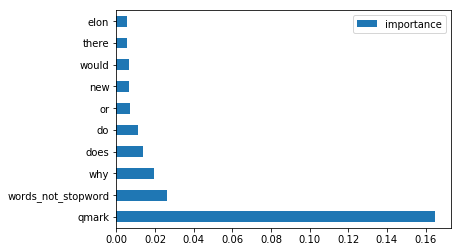

In [164]:
feat_importance2 = pd.DataFrame(et2.feature_importances_, tf_tr_df.columns, columns = ['importance'])

feat_importance2.sort_values('importance', ascending=False).head(10).plot(kind='barh')

**As expected, the qmark feature is highly important, but it is kind of cheating**

In [152]:
svc_params= [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
svc_grid = GridSearchCV(SVC(), svc_params, n_jobs=5)

In [153]:
svc_grid.fit(cv_tr_df, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid=[{'kernel': ['linear'], 'C': [1, 10]}, {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [155]:
bsvc= svc_grid.best_estimator_

In [157]:
svc_grid.score(cv_tr_df, y_train) #1.0

svc_grid.score(cv_te_df, y_test) #0.9799599198396793

1.0

In [160]:
## SVC is way too computationally expensive. Let's try gradient boost

In [165]:
gb_params= { 
    'n_estimators': [16, 32],
    'learning_rate': [0.8, 1.0]
}

gb_grid = GridSearchCV(GradientBoostingClassifier(), gb_params, cv= 5, n_jobs=5)
gb_grid.fit(cv_tr_df, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [166]:
gb_grid.score(cv_tr_df, y_train) #1.0

1.0

In [167]:
gb_grid.score(cv_te_df, y_test) #0.9819639278557114

0.9819639278557114

In [169]:
#Now test GradBoost with TFIDF

gb_grid2 = GridSearchCV(GradientBoostingClassifier(), gb_params, cv= 5, n_jobs=6)
gb_grid2.fit(tf_tr_df, y_train)

Exception in thread Thread-25:
Traceback (most recent call last):
  File "/home/omar/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/omar/miniconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/omar/miniconda3/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/home/omar/miniconda3/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/home/omar/miniconda3/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/home/omar/miniconda3/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/omar/miniconda3/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/omar/miniconda3/lib/python3.6/multiprocessing/popen_fork.py", line 19, in __in

AttributeError: 'NoneType' object has no attribute 'terminate'

In [ ]:
gb_grid2.score(tf_tr_df, y_train)

In [ ]:
gb_grid2.score(tf_te_df, y_test)

In [ ]:
# Next step is to test GradBoost with TFIDF, then decided if tfidf or count vec are more effective.
# Then remove the qmark column, and try it that way.

**Since I don't want to use meta info (like q mark), I'll just run off the sparse transformed matrices**

In [17]:
#Count Vecc options: Max_features, n_gram_range(), binary
#TFIDF: 
cv= CountVectorizer(stop_words=None, ngram_range=(1,3)) 
tfidf= TfidfVectorizer(stop_words=None, ngram_range=(1,3))

# Some Vectorizing notes:
# When Stop words are left in, all the top features are stop words
# When stop words are removed, test accuracy falls by about 4-5%
# when ngram range starts >1, accuracy suffers. (1,3) is best

trX_cv = cv.fit_transform(X_train['processed'])
teX_cv= cv.transform(X_test['processed'])

trX_tf = tfidf.fit_transform(X_train['processed'])
teX_tf= tfidf.transform(X_test['processed'])

In [89]:
s2_params= {
    {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
}

array([0.9602649 , 0.96      , 0.96666667, 0.95333333, 0.96      ,
       0.92      , 0.95973154, 0.91946309, 0.97315436, 0.95302013])

In [23]:
gb_params= { 
    'n_estimators': [50, 80],
    'learning_rate': [0.25, .15]
}

cv_gb = GridSearchCV(GradientBoostingClassifier(), gb_params, cv= 5, n_jobs=7, scoring='f1')
cv_gb.fit(trX_cv, y_train)

tf_gb = GridSearchCV(GradientBoostingClassifier(), gb_params, cv= 5, n_jobs=7, scoring='f1')
tf_gb.fit(trX_tf, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=7,
       param_grid={'n_estimators': [50, 80], 'learning_rate': [0.25, 0.15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [24]:
cv_gb.score(trX_cv, y_train),cv_gb.score(teX_cv, y_test)

(0.9927963326784545, 0.9241071428571428)

In [25]:
tf_gb.score(trX_tf, y_train),tf_gb.score(teX_tf, y_test)

(0.9947575360419397, 0.9166666666666666)

In [26]:
cv_gb.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.25, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [27]:
tf_gb.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.25, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [37]:
#Combine the above process into a function
def double_class(classifier, params, dense=False):
    cv_grid = tf_grid = GridSearchCV(classifier, params, cv= 5, n_jobs=7)#, scoring= 'f1')
    cv_grid.fit(trX_cv, y_train)
    tf_grid.fit(trX_tf, y_train)
    print('CV Stats:')
    print(cv_grid.score(trX_cv, y_train),cv_grid.score(teX_cv, y_test))
    print(cv_grid.best_estimator_)
#     print(cv_grid.get_params())
    print('\nTF Stats:')
    print(tf_grid.score(trX_tf, y_train),tf_grid.score(teX_tf, y_test))
    print(tf_grid.best_estimator_) 
#     print(tf_grid.get_params())

In [38]:
nbayes= MultinomialNB()
nbayes_params={
    
}
double_class(nbayes, nbayes_params)

CV Stats:
0.9986639946559787 0.9639278557114228
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

TF Stats:
1.0 0.9639278557114228
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [41]:
gbayes = GaussianNB() #It doesn't take a sparse matrix, so double_class won't work. 

tf_gnb = cv_gnb = GridSearchCV(gbayes, {}, n_jobs=7, cv=5)
tf_gnb.fit(trX_tf.toarray(), y_train)
cv_gnb.fit(trX_cv.toarray(), y_train)
print('CV Stats:')
print(cv_gnb.score(trX_cv.toarray(), y_train),cv_gnb.score(teX_cv.toarray(), y_test))
print(cv_gnb.best_estimator_)
#     print(cv_grid.get_params())
print('\nTF Stats:')
print(tf_gnb.score(trX_tf.toarray(), y_train),tf_gnb.score(teX_tf.toarray(), y_test))
print(tf_gnb.best_estimator_) 

CV Stats:
1.0 0.9498997995991983
GaussianNB(priors=None)

TF Stats:
1.0 0.9278557114228457
GaussianNB(priors=None)


In [34]:
ranfor= RandomForestClassifier()
ranfor_params = {
    'n_estimators': [6, 10, 15],
    'max_depth' : [5, 9, 14]
}
double_class(ranfor, ranfor_params)

CV Stats: 

0.8390113560454242 0.8176352705410822
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
TF Stats: 

0.9245156980627922 0.8276553106212425
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [31]:
extree= ExtraTreesClassifier(n_estimators=50, max_depth=20)
extree_params = {
#     'min_samples_leaf': [.005, .01, .02], # Even with full range of parameters, the ExtraTrees is overfitting,
#     'min_samples_split': [.01, .1, .15]   # and under performing
}
double_class(extree, extree_params)


CV Stats: 

0.9612558450233801 0.9198396793587175
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=20, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
TF Stats: 

0.978623914495658 0.9218436873747495
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=20, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [32]:
dtc = DecisionTreeClassifier()
dtc_params = {
    'max_depth': [25, 18, 20],
#     'max_features': ['sqrt', 'log2', .6]
    'min_samples_leaf': [.007, .008],#, .05],
    'min_samples_split': [.1, .07, .05]
}
double_class(dtc, dtc_params)

CV Stats: 

0.822311289245157 0.843687374749499
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.007, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
TF Stats: 

0.8984635938543755 0.8677354709418837
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.007, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [43]:
svc = SVC()
svc_params={
    'C': [.3, .8, 1],
    'kernel': ['rbf', 'linear', 'poly']
}

double_class(svc, svc_params)

CV Stats:
0.9986639946559787 0.9579158316633266
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

TF Stats:
1.0 0.9779559118236473
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [45]:
logreg= LogisticRegression()
logreg_params = {
    'penalty': ['l1', 'l2'],
    'C': [.05, .1, .2, .5, .9, 1]
}
double_class(logreg, logreg_params)

CV Stats:
0.9759519038076152 0.9458917835671342
LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

TF Stats:
0.9986639946559787 0.969939879759519
LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


**SVC with TFIDF seems to be performing the best, so I will fit a pipeline with both of those and Grid Search more deeply**

In [3]:
#Also going to include various Tokenizers
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer, SnowballStemmer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

class SnowballTokenizer(object):
    def __init__(self):
        self.sbs = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.sbs.stem(t) for t in word_tokenize(doc)]

In [113]:
tf_svc= Pipeline(steps=[
    ('tfidf', TfidfVectorizer(ngram_range=(1,4), tokenizer=SnowballTokenizer())),
    ('svc', SVC(kernel='linear' ))
])

pipe_params={
#     'tfidf__tokenizer':[None, LemmaTokenizer(), SnowballTokenizer() ],#, SnowballStemmer],# SnowballTokenizer(), LemmaTokenizer()], 
    'tfidf__max_features': [9000, 9500, 9750],#9000, 10000],
#     'tfidf__stop_words': [None, 'english'],
#     'tfidf__ngram_range':[(1,3), (1,4)],
    'svc__C':[.7, .75,  .8, .85],
#     'svc__'
#     'svc__'
    
}

tfsvc_grid= GridSearchCV(tf_svc, pipe_params, cv= 5, n_jobs=7)

In [114]:
#take2
tfsvc_grid.fit(X_train['processed'], y_train)

print(tfsvc_grid.score(X_train['processed'], y_train),tfsvc_grid.score(X_test['processed'], y_test))

0.9959919839679359 0.9799599198396793


In [115]:
# Cinco tuning
print(tfsvc_grid.best_params_)

{'svc__C': 0.8, 'tfidf__max_features': 9500}


In [112]:
# Quatro tuning
print(tfsvc_grid.best_params_)

{'svc__C': 0.8, 'tfidf__max_features': 9500}


In [109]:
# Third tuning
print(tfsvc_grid.best_params_)

{'svc__C': 0.8, 'tfidf__max_features': 9500}


In [106]:
# Second tuning
print(tfsvc_grid.best_params_)

{'svc__C': 0.7, 'tfidf__max_features': 9000, 'tfidf__ngram_range': (1, 4), 'tfidf__tokenizer': <__main__.SnowballTokenizer object at 0x7fd916ce72b0>}


In [102]:
# First one
print(tfsvc_grid.best_params_)

{'svc__C': 0.8, 'tfidf__max_features': 9000, 'tfidf__ngram_range': (1, 4), 'tfidf__tokenizer': <__main__.SnowballTokenizer object at 0x7fd915e24780>}


In [103]:
tfsvc_grid.best_estimator_.named_steps.tfidf.vocabulary_

{'if': 2758,
 'the': 7340,
 'graviti': 2421,
 'of': 3930,
 'moon': 3701,
 'is': 3038,
 'enough': 1940,
 'to': 7806,
 'creat': 1482,
 'tidal': 7773,
 'wave': 8264,
 'whi': 8403,
 'doesnt': 1738,
 'it': 3147,
 'lift': 3406,
 'up': 8144,
 'thing': 7728,
 'like': 3423,
 'tree': 8061,
 'leav': 3368,
 'or': 4141,
 'small': 6868,
 'anim': 585,
 'if the': 2785,
 'the graviti': 7442,
 'of the': 4014,
 'the moon': 7487,
 'moon is': 3706,
 'enough to': 1945,
 'to creat': 7847,
 'whi doesnt': 8425,
 'thing like': 7729,
 'of the moon': 4019,
 'common': 1352,
 'in': 2818,
 'young': 8979,
 'adult': 358,
 'when': 8375,
 'i': 2730,
 'assum': 732,
 'this': 7739,
 'would': 8908,
 'have': 2512,
 'been': 890,
 'a': 134,
 'serious': 6778,
 'disadvantag': 1647,
 'we': 8275,
 'were': 8326,
 'whi is': 8430,
 'common in': 1354,
 'when i': 8380,
 'would have': 8914,
 'have been': 2516,
 'been a': 891,
 'a serious': 254,
 'when we': 8390,
 'we were': 8307,
 'what': 8340,
 'make': 3521,
 'food': 2181,
 'fill': 211

In [122]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
import numpy as np

X=TfidfVectorizer(ngram_range=(1,4), tokenizer=SnowballTokenizer(), max_features=9500).fit_transform(X_train['processed'])

y= y_train

clf1 = MultinomialNB()
clf2 = LogisticRegression()
clf3 = SVC(kernel='linear', C= .8)
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('10-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['Naive Bayes', 
                       'LogReg', 
                       'SVC',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))
# It makes almost not difference between tfidf and countvec

5-fold cross validation:

Accuracy: 0.95 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [LogReg]
Accuracy: 0.96 (+/- 0.01) [SVC]
Accuracy: 0.96 (+/- 0.02) [StackingClassifier]


**^The above Stacking Classifier is promising, but after lots of parameter tuning I've settled on this pipeline:**

In [4]:
final_pipe= Pipeline(steps=[
    ('tfidf', TfidfVectorizer(ngram_range=(1,4), tokenizer=SnowballTokenizer(), max_features=9500)),
    ('svc', SVC(C= .8, kernel='linear' ))
])
# With 5-fold Cross Validation, this gets 98% accuracy on test set (processed) data. 

In [5]:
from sklearn.externals import joblib
joblib.dump(final_pipe, './tf_svc_pipe.pkl')

['./tf_svc_pipe.pkl']

In [117]:
final_pipe.fit(X_train['processed'], y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=9500, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
 ...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [118]:
final_pipe.score(X_train['processed'], y_train)

0.9959919839679359

In [119]:
final_pipe.score(X_test['processed'], y_test)

0.9799599198396793